In [18]:
from dashboard import test_data, optimal_params_train, optimal_params_generated, n_finish_select, n_start_select

In [19]:
train_returns = strategy_return(test_data, nf=optimal_params_train['n_finish'],
                                    ns=optimal_params_train['n_start']).cumsum()
fake_returns = strategy_return(test_data, nf=optimal_params_generated['n_finish'],
                               ns=optimal_params_generated['n_start']).cumsum()
custom_returns = strategy_return(test_data, nf=int(n_finish_select.value),
                                 ns=int(n_start_select.value)).cumsum()

In [20]:
import matplotlib.pyplot as plt

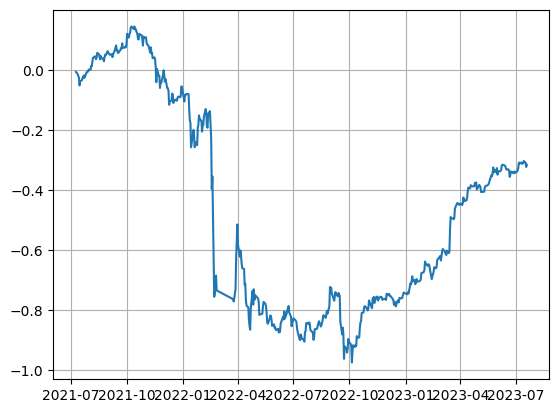

In [22]:
plt.plot(train_returns)
plt.grid()

## BOOTSTRAP

In [25]:
from dashboard import get_optimal_params, heatmap_real_source, N_START_VALUES, N_FINISH_VALUES

In [34]:
from dashboard import sharp_grid

In [27]:
optimal_params_train

{'n_start': 80, 'n_finish': 300}

In [ ]:
import numpy as np
import pandas as pd
from bokeh.models import ColumnDataSource

def bootstrap_multivariate_time_series(data, n_samples=100, block_length=None):
    """
    Блоковый бутстреп для многомерного временного ряда.
    
    Parameters:
    - data: DataFrame где каждая колонка - это отдельный временной ряд (акция)
    - n_samples: количество бутстреп-выборок
    - block_length: длина блоков. Если None, будет выбрана автоматически.
    
    Returns:
    - Список бутстреп-выборок (DataFrame)
    """
    n = len(data)
    if block_length is None:
        block_length = int(np.sqrt(n)) if n > 100 else 10
    
    bootstrap_samples = []
    
    for _ in range(n_samples):
        new_sample = pd.DataFrame(np.zeros_like(data), 
                                 index=data.index, 
                                 columns=data.columns)
        i = 0
        while i < n:
            start = np.random.randint(0, n - block_length + 1)
            end = start + block_length
            block = data.iloc[start:end]
            
            remaining_space = n - i
            block_to_add = block.iloc[:remaining_space]
            new_sample.iloc[i:i+len(block_to_add)] = block_to_add.values
            i += len(block_to_add)
            
        bootstrap_samples.append(new_sample)
    
    return bootstrap_samples

def bootstrap_optimal_params(original_data, heatmap_real_source, n_bootstrap=100, 
                           n_start_values=None, n_finish_values=None):
    """
    Получение оптимальных параметров стратегии с помощью бутстрепа.
    
    Parameters:
    - original_data: DataFrame с доходностями нескольких акций
    - heatmap_real_source: исходный ColumnDataSource
    - n_bootstrap: количество бутстреп-выборок
    - n_start_values, n_finish_values: параметры для get_optimal_params
    
    Returns:
    - Список кортежей с оптимальными параметрами для каждой выборки
    """
    bootstrap_samples = bootstrap_multivariate_time_series(original_data, n_samples=n_bootstrap)
    
    all_optimal_params = []
    
    for sample in bootstrap_samples:
        # Преобразуем бутстреп-выборку
        heatmap_real_values = sharp_grid(sample).flatten()
        
        # Создаем НОВЫЙ ColumnDataSource с теми же данными, кроме values
        new_source = ColumnDataSource(data={
            'values': heatmap_real_values,
            # Копируем все остальные колонки из исходного источника
            **{key: np.array(heatmap_real_source.data[key]) 
               for key in heatmap_real_source.data 
               if key != 'values'}
        })
        
        # Получаем оптимальные параметры для этой выборки
        params = get_optimal_params(new_source, 
                                   n_start_values or N_START_VALUES, 
                                   n_finish_values or N_FINISH_VALUES)
        all_optimal_params.append(params)
    
    return all_optimal_params


# Пример использования
if __name__ == "__main__":
    # Предполагаем что:
    # df_returns_real - DataFrame с доходностями 5 акций
    # heatmap_real_source - исходный ColumnDataSource
    bootstrap_params = bootstrap_optimal_params(
        df_returns_real, 
        heatmap_real_source, 
        n_bootstrap=100
    )
    
    # Анализ результатов
    print(f"Всего бутстреп-выборок: {len(bootstrap_params)}")
    print("Первые 5 наборов параметров:")
    for params in bootstrap_params[:5]:
        print(params)
    

In [41]:
# Предположим, что bootstrap_params - это список словарей параметров
# Пример: [{'param1': 0.5, 'param2': 1.2}, {'param1': 0.6, 'param2': 1.1}, ...]

# Собираем все значения для каждого параметра
param_stats = {}
for param_name in bootstrap_params[0].keys():
    values = [params[param_name] for params in bootstrap_params]
    param_stats[param_name] = {
        'mean': np.mean(values),
        'std': np.std(values),
        'median': np.median(values),
        'min': np.min(values),
        'max': np.max(values),
        'q5': np.percentile(values, 5),
        'q95': np.percentile(values, 95)
    }

# Выводим статистику в удобном формате
print("\nСтатистика параметров:")
for param_name, stats in param_stats.items():
    print(f"\nПараметр: {param_name}")
    print(f"  Среднее: {stats['mean']:.4f} ± {stats['std']:.4f}")
    print(f"  Медиана: {stats['median']:.4f}")
    print(f"  Диапазон: [{stats['min']:.4f}, {stats['max']:.4f}]")
    print(f"  90% дов. интервал: [{stats['q5']:.4f}, {stats['q95']:.4f}]")

# Дополнительно можно создать DataFrame для удобства анализа
import pandas as pd
stats_df = pd.DataFrame.from_dict(param_stats, orient='index')
print("\nТабличное представление статистики:")
print(stats_df)


Статистика параметров:

Параметр: n_start
  Среднее: 54.2000 ± 30.8927
  Медиана: 60.0000
  Диапазон: [20.0000, 100.0000]
  90% дов. интервал: [20.0000, 100.0000]

Параметр: n_finish
  Среднее: 271.5000 ± 95.4607
  Медиана: 250.0000
  Диапазон: [150.0000, 400.0000]
  90% дов. интервал: [150.0000, 400.0000]

Табличное представление статистики:
           mean        std  median  min  max     q5    q95
n_start    54.2  30.892718    60.0   20  100   20.0  100.0
n_finish  271.5  95.460725   250.0  150  400  150.0  400.0


In [26]:
optimal_params_train = get_optimal_params(heatmap_real_source, N_START_VALUES, N_FINISH_VALUES)

In [54]:
bootstrap_samples = bootstrap_multivariate_time_series(df_returns_real, n_samples=3)

<Axes: xlabel='date'>

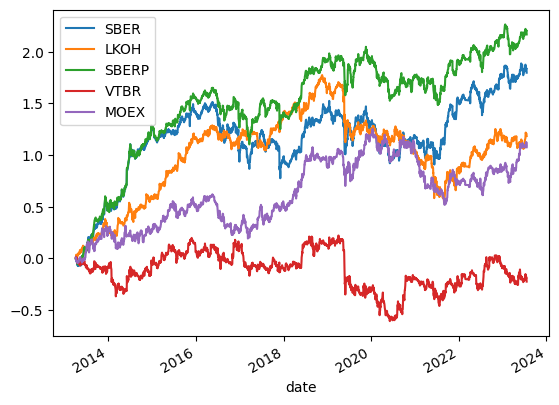

In [55]:
bootstrap_samples[0].cumsum().plot()

<Axes: xlabel='date'>

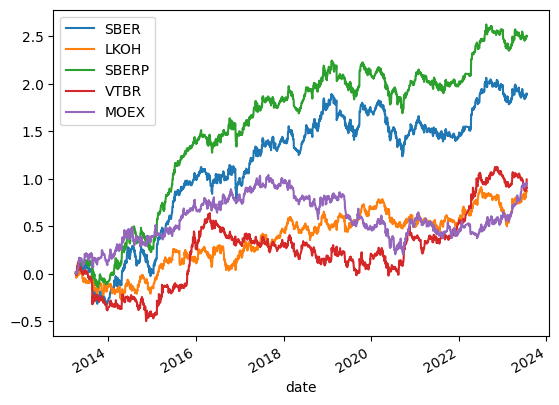

In [56]:
bootstrap_samples[1].cumsum().plot()

<Axes: xlabel='date'>

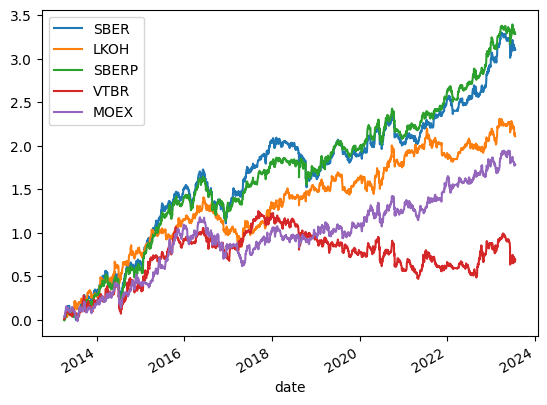

In [57]:
bootstrap_samples[2].cumsum().plot()

In [51]:
len(df_returns_real)

2576

In [53]:
2576**0.5

50.75431016179808